# Objective- Apply Naive Bayes on amazon fine food reviews

#### codes for-
* feature importance
* apply naive bayes on amazon fine food reviews dataset
* find best alpha using cross validation
* find confusion_matrix, accuracy, recall, f1 score, precision


#### About the datasets

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.feature_extraction.text import CountVectorizer
import pylab as pl
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the data

In [7]:
sql=sqlite3.connect('database.sqlite')  #loading sql data
data=pd.read_sql_query('''
SELECT *
FROM Reviews
WHERE Score!=3''',sql)

In [8]:
data.columns  #column names in the dataset

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [9]:
#for changing score int value to positive and negative i.e only in two class
def posneg(x):
    if x<3:
        return 0
    else:
        return 1
score=data['Score']
data['Score']=score.map(posneg)

In [10]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Data cleaning

In [11]:
data=data[data['HelpfulnessNumerator']<=data['HelpfulnessDenominator']] 

In [12]:
data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=True) #droping the duplicates
data.shape

(364171, 10)

In [13]:
stop=set(stopwords.words('english'))

In [14]:

sno=nltk.stem.SnowballStemmer('english')  #stemmer of english language

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [15]:
#taking sample of data
sample=data.sample(200000)
sample_data=sample.sort_values(['Time'])  #sorting data on time basis
sample_score=sample_data['Score']

In [16]:
#filtering sentence
import re
final_string=[]
s=''
for sentence in sample_data['Text']:
    filtered_sentence=[]
    cleaned_sentence=cleanhtml(sentence)
    for words in sentence.split():
        cleaned_words=cleanpunc(words)
        if ( (cleaned_words.isalpha()) & (len(cleaned_words)>2) ):
            if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
            else: 
                continue
        else:
            continue
    str1=b" ".join(filtered_sentence)    
    final_string.append(str1)
        

In [17]:
sample_data['Cleaned_text']=final_string  #creating a new column in sample_data

In [18]:
sample_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year sister late...
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur star michael keat...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni keaton hilari wacki g...


In [19]:
sample_data['Score'].value_counts()

1    168637
0     31363
Name: Score, dtype: int64

## Upsampling

In [20]:
#taking the test data seperate from all other

train,test=cross_validation.train_test_split(sample_data,test_size=0.3) #splitting the data

In [21]:
train['Score'].value_counts()

1    117965
0     22035
Name: Score, dtype: int64

In [22]:
test['Score'].value_counts()

1    50672
0     9328
Name: Score, dtype: int64

In [23]:
from sklearn.utils import resample

In [24]:
df_majority = train[train['Score']==1]
df_minority = train[train['Score']==0]
 

In [25]:
#upsampling on train data
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=117965,    # to match majority class
                                 random_state=123) # reproducible results


In [26]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled['Score'].value_counts()

1    117965
0    117965
Name: Score, dtype: int64

In [27]:
df_upsampled=df_upsampled.sort_values(['Time'])

X=df_upsampled['Cleaned_text']
y=df_upsampled['Score']

In [28]:
# universal x_test and y_test 
x_test=test['Cleaned_text']
y_test=test['Score']

In [29]:
result=pd.DataFrame(columns=['sno.','featurization', 'naive bayes algo', 'k-fold cv algo', 'scoring', 'best alpha', 'accuracy', 'TNR', 'TPR', 'FNR', 'FPR'])

## 1.1 Multinomial naive bayes using Bag of words representation

### 1. Multinomial NB for Binary Bag of words , 10 fold cross validation , scoring='accuracy'

In [30]:
#binary BoW
count_vec=CountVectorizer(binary=True)
x_train=count_vec.fit_transform(X.values)

In [31]:
x_test=count_vec.transform(x_test)

In [32]:
import seaborn as sns

In [33]:
# defining naive bayes function that does cross validation , plotting error vs alpha, accuracy, classification report and confusion matrix
# this function takes 'algo', 'scoring', 'x_train', 'x_test', 'y_train', 'y_test' as arguments
# this function returns 'scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR', where accu stands for accuracy
def naive_bayes(algo, scoring, x_train, x_test, y_train, y_test):
    #cross validation
    cv_score=[]
    alph=list(pl.frange(1,100,1))
    alph=[round(x,4) for x in alph]
    for i in alph:
        if(algo=='multi'):
            clf=MultinomialNB(alpha=i)
        elif(algo=='bernoulli'):
            clf=BernoulliNB(alpha=i)
        score=cross_val_score(estimator=clf,X=x_train,y=y_train,cv=10,n_jobs=1,scoring=scoring)
        cv_score.append(score.mean())
        
    #misclassification error and optimal_alpha
    MSE=[1-x for x in cv_score] #misclassification error
    optimal_alpha=alph[MSE.index(min(MSE))]
    print('optimal_alpha=',optimal_alpha)
    print('************************************************')
    
    #plot between error and alpha
    plt.plot(alph, MSE)
    plt.xlabel('alpha value')
    plt.ylabel('misclassification error')
    plt.title('plot of alpha vs misclassification error')
    plt.show()
    print('************************************************')
    
    #defining model with optimal_alpha
    if(algo=='multi'):
        clf=MultinomialNB(alpha=optimal_alpha)
    elif(algo=='bernoulli'):
        clf=BernoulliNB(alpha=optimal_alpha)
    clf.fit(x_train,y_train)
    y_pred=clf.predict(x_test)
    
    #finding accuracy
    accu=accuracy_score(y_test,y_pred)*100
    print('accuracy=',accu)
    print('************************************************')
    
    #classification report
    print(classification_report(y_test, y_pred))
    print('************************************************')
    
    #confusion matrix
    t=metrics.confusion_matrix(y_pred,y_test)
    heatmap = sns.heatmap(t, annot=True, fmt="d", xticklabels=True, yticklabels=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()
    print('************************************************')
    
    #TPR, TNR, FPR, FNR
    TNR=t[0][0]/(t[0][0]+t[1][0])
    TPR=t[1][1]/(t[0][1]+t[1][1])
    FPR=t[1][0]/(t[0][0]+t[1][0])
    FNR=t[0][1]/(t[0][1]+t[1][1])
    print('TNR=',TNR)
    print('TPR=',TPR)
    print('FPR=',FPR)
    print('FNR=',FNR)
    
    return scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR


optimal_alpha= 39
************************************************


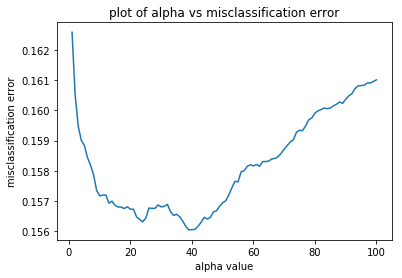

************************************************
accuracy= 83.755
************************************************
             precision    recall  f1-score   support

          0       0.49      0.85      0.62      9328
          1       0.97      0.84      0.90     50672

avg / total       0.89      0.84      0.85     60000

************************************************


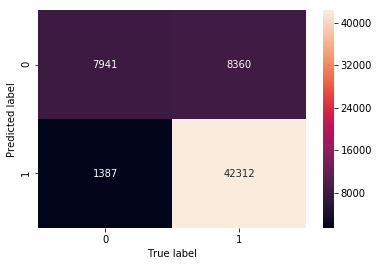

************************************************
TNR= 0.8513078902229846
TPR= 0.8350173665929902
FPR= 0.14869210977701544
FNR= 0.16498263340700978


In [34]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='multi', scoring='accuracy', x_train=x_train, x_test=x_test, y_train=y, y_test=y_test)

In [35]:
new=[1,'Bag of words', 'Multinomial NB' , '10 fold cv', scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[0]=new

### 2. Multinomial NB for Binary Bag of words , 10 fold cross validation , scoring='average_precision'

optimal_alpha= 71
************************************************


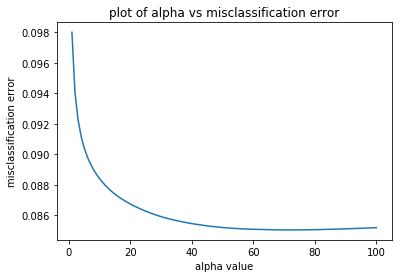

************************************************
accuracy= 82.44500000000001
************************************************
             precision    recall  f1-score   support

          0       0.47      0.87      0.61      9328
          1       0.97      0.82      0.89     50672

avg / total       0.89      0.82      0.84     60000

************************************************


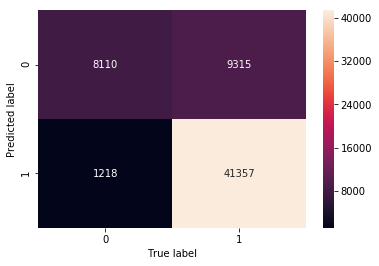

************************************************
TNR= 0.8694253859348199
TPR= 0.8161706662456584
FPR= 0.1305746140651801
FNR= 0.18382933375434166


In [36]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='multi', scoring='average_precision', x_train=x_train, x_test=x_test, y_train=y, y_test=y_test)

In [37]:
new=[2,'Bag of words', 'Multinomial NB' , '10 fold cv', scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[1]=new

### 3.  Multinomial NB for Binary Bag of words , 10 fold cross validation , scoring='f1'

optimal_alpha= 9
************************************************


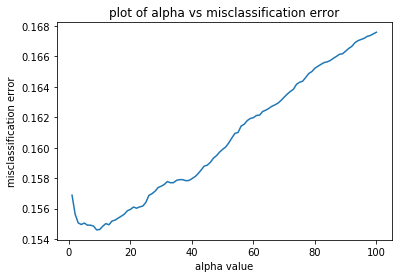

************************************************
accuracy= 85.61666666666666
************************************************
             precision    recall  f1-score   support

          0       0.52      0.83      0.64      9328
          1       0.96      0.86      0.91     50672

avg / total       0.90      0.86      0.87     60000

************************************************


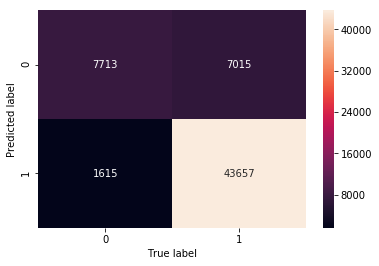

************************************************
TNR= 0.8268653516295026
TPR= 0.8615606251973477
FPR= 0.17313464837049744
FNR= 0.13843937480265237


In [38]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='multi', scoring='f1', x_train=x_train, x_test=x_test, y_train=y, y_test=y_test)

In [39]:
new=[3,'Bag of words', 'Multinomial NB' , '10 fold cv', scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[2]=new

### 4.  Multinomial NB for Binary Bag of words , 10 fold cross validation , scoring='recall'

optimal_alpha= 1
************************************************


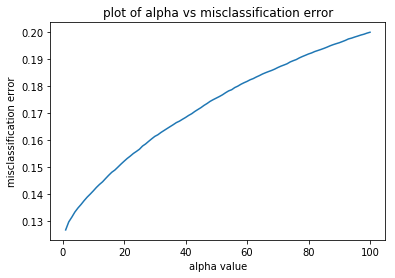

************************************************
accuracy= 86.29333333333334
************************************************
             precision    recall  f1-score   support

          0       0.54      0.81      0.65      9328
          1       0.96      0.87      0.92     50672

avg / total       0.90      0.86      0.87     60000

************************************************


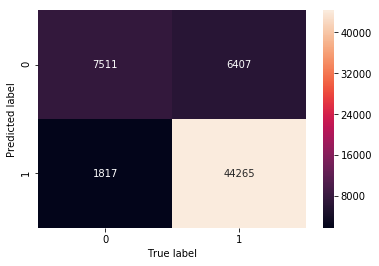

************************************************
TNR= 0.8052101200686106
TPR= 0.8735593621724029
FPR= 0.19478987993138935
FNR= 0.1264406378275971


In [40]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='multi', scoring='recall', x_train=x_train, x_test=x_test, y_train=y, y_test=y_test)

In [41]:
new=[4,'Bag of words', 'Multinomial NB' , '10 fold cv', scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[3]=new

## 1.2 Bernoulli naive bayes using Binary Bag of words

### 5.  BernoulliNB for Binary Bag of words , 10 fold cross validation , scoring='accuracy'

optimal_alpha= 7
************************************************


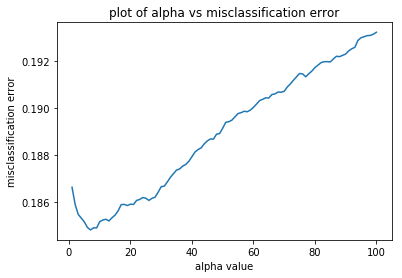

************************************************
accuracy= 86.13666666666666
************************************************
             precision    recall  f1-score   support

          0       0.54      0.75      0.63      9328
          1       0.95      0.88      0.91     50672

avg / total       0.89      0.86      0.87     60000

************************************************


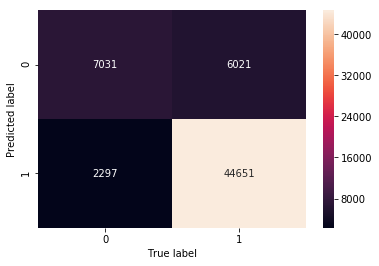

************************************************
TNR= 0.7537521440823327
TPR= 0.881176981370382
FPR= 0.24624785591766724
FNR= 0.11882301862961793


In [42]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='bernoulli', scoring='accuracy', x_train=x_train, x_test=x_test, y_train=y, y_test=y_test)

In [43]:
new=[5, 'Bag of words', 'Bernoulli NB' ,'10 fold cv', scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[4]=new

### 6.  BernoulliNB for Binary Bag of words , 10 fold cross validation , scoring='average_precision'

optimal_alpha= 25
************************************************


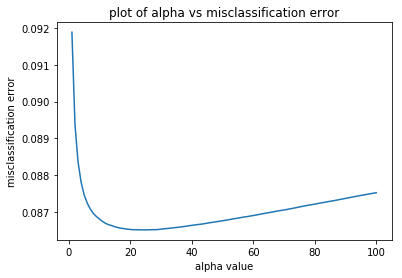

************************************************
accuracy= 86.08333333333333
************************************************
             precision    recall  f1-score   support

          0       0.54      0.75      0.63      9328
          1       0.95      0.88      0.91     50672

avg / total       0.89      0.86      0.87     60000

************************************************


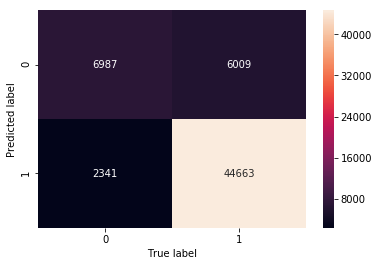

************************************************
TNR= 0.7490351629502573
TPR= 0.8814137985475213
FPR= 0.2509648370497427
FNR= 0.11858620145247868


In [44]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='bernoulli', scoring='average_precision', x_train=x_train, x_test=x_test, y_train=y, y_test=y_test)

In [45]:
new=[6,'Bag of words', 'Bernoulli NB' ,'10 fold cv', 'average_precision', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[5]=new

### 7.  BernoulliNB for Binary Bag of words , 10 fold cross validation , scoring='f1'

optimal_alpha= 7
************************************************


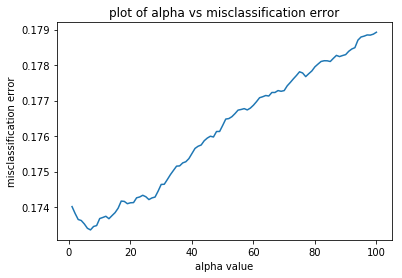

************************************************
accuracy= 86.13666666666666
************************************************
             precision    recall  f1-score   support

          0       0.54      0.75      0.63      9328
          1       0.95      0.88      0.91     50672

avg / total       0.89      0.86      0.87     60000

************************************************


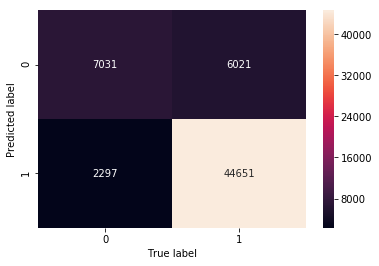

************************************************
TNR= 0.7537521440823327
TPR= 0.881176981370382
FPR= 0.24624785591766724
FNR= 0.11882301862961793


In [46]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='bernoulli', scoring='f1', x_train=x_train, x_test=x_test, y_train=y, y_test=y_test)

In [47]:
new=[7,'Bag of words', 'Bernoulli NB' ,'10 fold cv', 'f1', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[6]=new

### 8.  BernoulliNB for Binary Bag of words , 10 fold cross validation , scoring='recall'

optimal_alpha= 100
************************************************


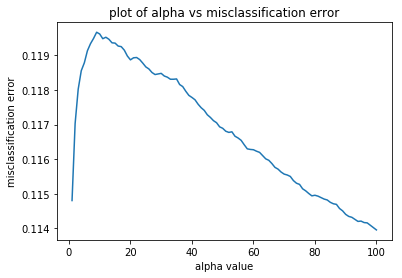

************************************************
accuracy= 86.17166666666667
************************************************
             precision    recall  f1-score   support

          0       0.54      0.73      0.62      9328
          1       0.95      0.89      0.92     50672

avg / total       0.88      0.86      0.87     60000

************************************************


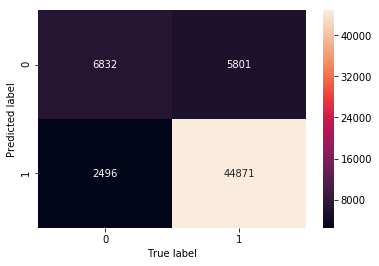

************************************************
TNR= 0.7324185248713551
TPR= 0.8855186296179349
FPR= 0.26758147512864494
FNR= 0.11448137038206505


In [48]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='bernoulli', scoring='recall', x_train=x_train ,x_test=x_test, y_train=y, y_test=y_test)

In [49]:
new=[8,'Bag of words', 'Bernoulli NB' ,'10 fold cv', 'recall', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[7]=new

## 2.1 Multinomial naive bayes using Binary TF-IDF 

### 9. Multinomial NB for Binary TF-IDF , 10 fold cross validation , scoring='accuracy'

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
df_majority = train[train['Score']==1]
df_minority = train[train['Score']==0]


df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=117965,    # to match majority class
                                 random_state=123) # reproducible results


df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled['Score'].value_counts()

1    117965
0    117965
Name: Score, dtype: int64

In [52]:
df_upsampled=df_upsampled.sort_values(['Time'])

x_train=df_upsampled['Cleaned_text']
y_train=df_upsampled['Score']

In [53]:
x_test=test['Cleaned_text']
y_test=test['Score']

In [54]:
#binary tfidf
tfidf=TfidfVectorizer(ngram_range=(1,1), binary=True)
x_train=tfidf.fit_transform(x_train)

In [55]:
x_test=tfidf.transform(x_test)

optimal_alpha= 48
************************************************


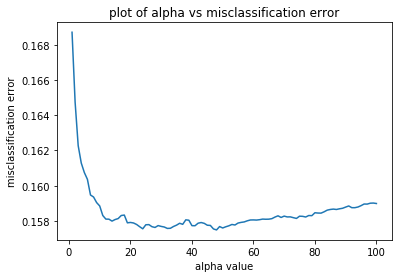

************************************************
accuracy= 82.61666666666667
************************************************
             precision    recall  f1-score   support

          0       0.47      0.87      0.61      9328
          1       0.97      0.82      0.89     50672

avg / total       0.89      0.83      0.84     60000

************************************************


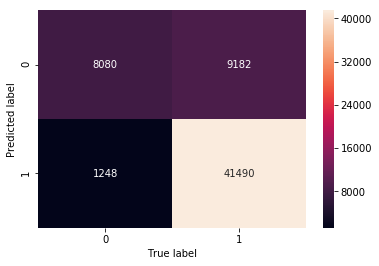

************************************************
TNR= 0.8662092624356775
TPR= 0.8187953899589517
FPR= 0.13379073756432247
FNR= 0.18120461004104832


In [56]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='multi', scoring='accuracy', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [57]:
new=[9,'TF-IDF', 'Multinomial NB' ,'10 fold cv', 'accuracy', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[8]=new

### 10. Multinomial NB for Binary TF-IDF , 10 fold cross validation , scoring='average_precision'

optimal_alpha= 40
************************************************


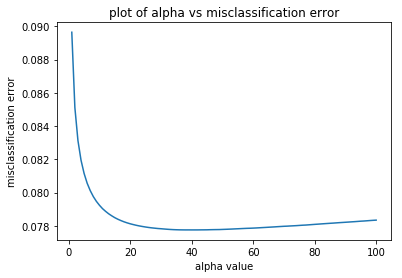

************************************************
accuracy= 82.77166666666666
************************************************
             precision    recall  f1-score   support

          0       0.47      0.87      0.61      9328
          1       0.97      0.82      0.89     50672

avg / total       0.89      0.83      0.85     60000

************************************************


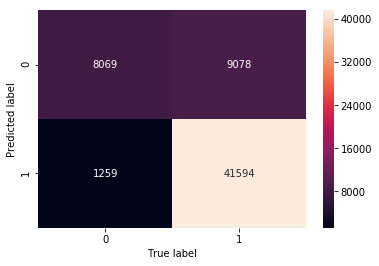

************************************************
TNR= 0.8650300171526587
TPR= 0.8208478054941585
FPR= 0.13496998284734132
FNR= 0.1791521945058415


In [58]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='multi', scoring='average_precision', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [59]:
new=[10,'TF-IDF', 'Multinomial NB' ,'10 fold cv', 'average_precision', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[9]=new

### 11. Multinomial NB for Binary TF-IDF , 10 fold cross validation , scoring='f1'

optimal_alpha= 11
************************************************


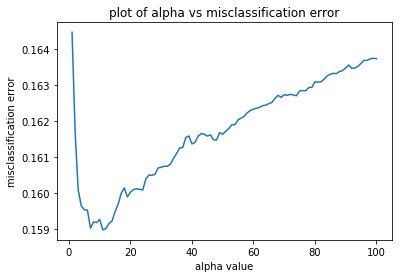

************************************************
accuracy= 84.09
************************************************
             precision    recall  f1-score   support

          0       0.49      0.85      0.62      9328
          1       0.97      0.84      0.90     50672

avg / total       0.89      0.84      0.86     60000

************************************************


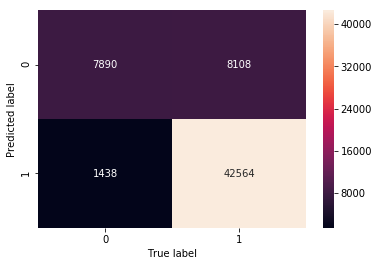

************************************************
TNR= 0.8458404802744426
TPR= 0.8399905273129145
FPR= 0.15415951972555747
FNR= 0.16000947268708557


In [60]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='multi', scoring='f1', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [61]:
new=[11,'TF-IDF', 'Multinomial NB' ,'10 fold cv', 'f1', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[10]=new

### 12. Multinomial NB for Binary TF-IDF , 10 fold cross validation , scoring='recall'

optimal_alpha= 1
************************************************


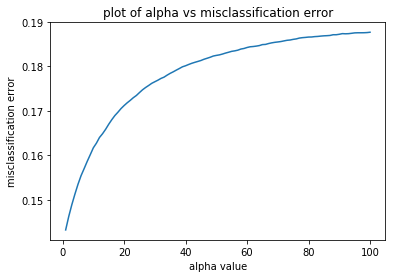

************************************************
accuracy= 85.005
************************************************
             precision    recall  f1-score   support

          0       0.51      0.81      0.63      9328
          1       0.96      0.86      0.91     50672

avg / total       0.89      0.85      0.86     60000

************************************************


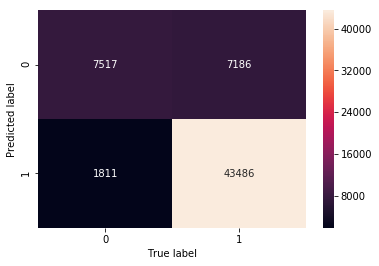

************************************************
TNR= 0.8058533447684391
TPR= 0.8581859804231133
FPR= 0.19414665523156088
FNR= 0.14181401957688664


In [62]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='multi', scoring='recall', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [63]:
new=[12,'TF-IDF', 'Multinomial NB' ,'10 fold cv', 'recall', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[11]=new

## 2.2 Bernoulli naive bayes using Binary Tfidf

### 13. Bernoulli NB for Binary TF-IDF , 10 fold cross validation , scoring='accuracy'

optimal_alpha= 7
************************************************


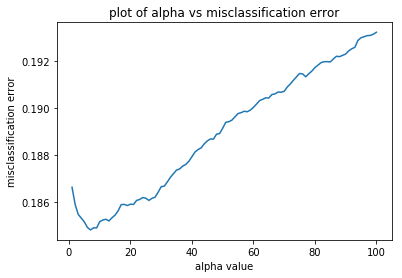

************************************************
accuracy= 86.13666666666666
************************************************
             precision    recall  f1-score   support

          0       0.54      0.75      0.63      9328
          1       0.95      0.88      0.91     50672

avg / total       0.89      0.86      0.87     60000

************************************************


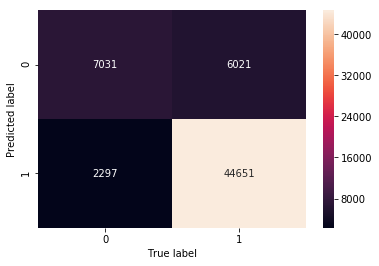

************************************************
TNR= 0.7537521440823327
TPR= 0.881176981370382
FPR= 0.24624785591766724
FNR= 0.11882301862961793


In [64]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='bernoulli', scoring='accuracy', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [65]:
new=[13,'TF-IDF', 'Bernoulli NB' ,'10 fold cv', 'accuracy', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[12]=new

### 14. Bernoulli NB for Binary TF-IDF , 10 fold cross validation , scoring='average_precision'

optimal_alpha= 25
************************************************


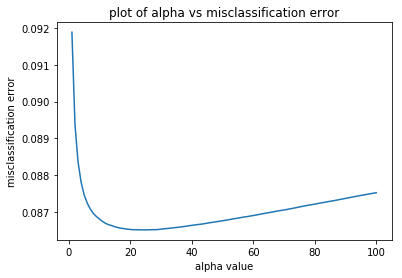

************************************************
accuracy= 86.08333333333333
************************************************
             precision    recall  f1-score   support

          0       0.54      0.75      0.63      9328
          1       0.95      0.88      0.91     50672

avg / total       0.89      0.86      0.87     60000

************************************************


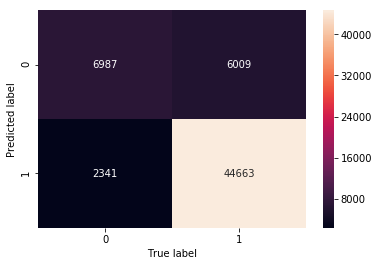

************************************************
TNR= 0.7490351629502573
TPR= 0.8814137985475213
FPR= 0.2509648370497427
FNR= 0.11858620145247868


In [66]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='bernoulli', scoring='average_precision', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [67]:
new=[14,'TF-IDF', 'Bernoulli NB' ,'10 fold cv', 'average_precision', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[13]=new

### 15. Bernoulli NB for Binary TF-IDF , 10 fold cross validation , scoring='f1'

optimal_alpha= 7
************************************************


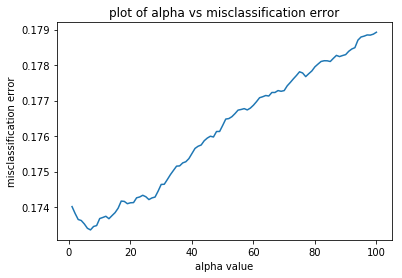

************************************************
accuracy= 86.13666666666666
************************************************
             precision    recall  f1-score   support

          0       0.54      0.75      0.63      9328
          1       0.95      0.88      0.91     50672

avg / total       0.89      0.86      0.87     60000

************************************************


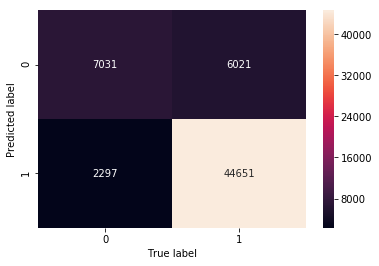

************************************************
TNR= 0.7537521440823327
TPR= 0.881176981370382
FPR= 0.24624785591766724
FNR= 0.11882301862961793


In [68]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='bernoulli', scoring='f1', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [69]:
new=[15,'TF-IDF', 'Bernoulli NB' ,'10 fold cv', 'f1', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[14]=new

### 16. Bernoulli NB for Binary TF-IDF , 10 fold cross validation , scoring='recall'

optimal_alpha= 100
************************************************


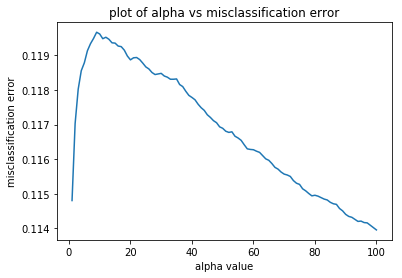

************************************************
accuracy= 86.17166666666667
************************************************
             precision    recall  f1-score   support

          0       0.54      0.73      0.62      9328
          1       0.95      0.89      0.92     50672

avg / total       0.88      0.86      0.87     60000

************************************************


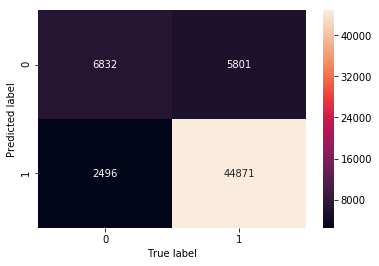

************************************************
TNR= 0.7324185248713551
TPR= 0.8855186296179349
FPR= 0.26758147512864494
FNR= 0.11448137038206505


In [70]:
scoring, optimal_alpha, accu, TNR, TPR, FNR, FPR=naive_bayes(algo='bernoulli', scoring='recall', x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

In [71]:
new=[16,'TF-IDF', 'Bernoulli NB' ,'10 fold cv', 'recall', optimal_alpha, accu, TNR, TPR, FNR, FPR]
result.loc[15]=new

In [72]:
#final table
result

,sno.,featurization,naive bayes algo,k-fold cv algo,scoring,best alpha,accuracy,TNR,TPR,FNR,FPR
0,1,Bag of words,Multinomial NB,10 fold cv,accuracy,39,83.755000,0.851308,0.835017,0.164983,0.148692
1,2,Bag of words,Multinomial NB,10 fold cv,average_precision,71,82.445000,0.869425,0.816171,0.183829,0.130575
2,3,Bag of words,Multinomial NB,10 fold cv,f1,9,85.616667,0.826865,0.861561,0.138439,0.173135
3,4,Bag of words,Multinomial NB,10 fold cv,recall,1,86.293333,0.805210,0.873559,0.126441,0.194790
4,5,Bag of words,Bernoulli NB,10 fold cv,accuracy,7,86.136667,0.753752,0.881177,0.118823,0.246248
5,6,Bag of words,Bernoulli NB,10 fold cv,average_precision,25,86.083333,0.749035,0.881414,0.118586,0.250965
6,7,Bag of words,Bernoulli NB,10 fold cv,f1,7,86.136667,0.753752,0.881177,0.118823,0.246248
7,8,Bag of words,Bernoulli NB,10 fold cv,recall,100,86.171667,0.732419,0.885519,0.114481,0.267581
8,9,TF-IDF,Multinomial NB,10 fold cv,accuracy,48,82.616667,0.866209,0.818795,0.181205,0.133791
9,10,TF-IDF,Multinomial NB,10 fold cv,average_precision,40,82.771667,0.865030,0.820848,0.179152,0.134970


### Observation-
* For Bag of words we can say alpha=9 and MultinomialNB is good. 

* For Tfidf we can say alpha=11 and MultinomialNB is the good.



## Feature importance using the best alpha for Bag of words representation (alpha=9, MultinomialNB)

In [87]:
df_majority = train[train['Score']==1]
df_minority = train[train['Score']==0]


df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=117965,    # to match majority class
                                 random_state=123) # reproducible results


df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled['Score'].value_counts()

1    117965
0    117965
Name: Score, dtype: int64

In [88]:
df_upsampled=df_upsampled.sort_values(['Time'])

x_train=df_upsampled['Cleaned_text']
y_train=df_upsampled['Score']

In [89]:
#Bag of word featurization
count_vect=CountVectorizer(binary=True)
x_train=count_vect.fit_transform(x_train.values)

In [90]:
#training the data
clf=MultinomialNB(alpha=9)
clf.fit(x_train,y_train)

MultinomialNB(alpha=9, class_prior=None, fit_prior=True)

In [91]:
#finding the top 50 negative class words
neg_f_imp=clf.feature_log_prob_[0].argsort()[-50:]
neg_sort=np.sort(clf.feature_log_prob_[0])[-50:]
print('top 50 frequent words occur in negative class and their log_prob--')
for i in range(50):
    print(np.take(count_vect.get_feature_names(),neg_f_imp[i])," : ",neg_sort[i])


top 50 frequent words occur in negative class and their log_prob--
bad  :  -5.981273985986482
two  :  -5.961439337684521
receiv  :  -5.960585822216084
someth  :  -5.9581360153776135
find  :  -5.943561884777539
also  :  -5.918403976345216
say  :  -5.898463035214725
better  :  -5.898362819751396
coffe  :  -5.891770706386673
never  :  -5.891770706386673
review  :  -5.887796533247396
littl  :  -5.883344386392979
bag  :  -5.863309511519839
made  :  -5.852243726242751
packag  :  -5.8432887268934195
thought  :  -5.831222215480304
give  :  -5.824032977662645
got  :  -5.808982603552465
know  :  -5.803316866016788
amazon  :  -5.791090114053986
didnt  :  -5.786509747700407
food  :  -5.748185493594162
could  :  -5.744656027527631
first  :  -5.732187889922368
box  :  -5.720544153917707
think  :  -5.712107400036601
time  :  -5.6879464745913175
purchas  :  -5.680181958067438
want  :  -5.668726712044023
eat  :  -5.597786978129546
bought  :  -5.576280772908582
love  :  -5.52125471103607
look  :  -5.503

In [92]:
#finding the top 50 positive class word
pos_f_imp=clf.feature_log_prob_[1].argsort()[-50:]
pos_sort=np.sort(clf.feature_log_prob_[1])[-50:]
print('top 50 frequent words occur in negative class and their log_prob--')
for i in range(50):
    print(np.take(count_vect.get_feature_names(),pos_f_imp[i])," : ",pos_sort[i])


top 50 frequent words occur in negative class and their log_prob--
need  :  -6.030291398619177
bag  :  -6.029436018839522
keep  :  -6.028093327151687
made  :  -6.025900076607575
think  :  -6.00876438520811
bought  :  -6.003037812650907
mix  :  -5.985935314060015
enjoy  :  -5.963615798359596
first  :  -5.9378749325758715
well  :  -5.9299925714754895
drink  :  -5.927783358161189
store  :  -5.912019484928125
look  :  -5.894363735092147
tea  :  -5.892018818221455
high  :  -5.884382764572548
want  :  -5.882377381030674
give  :  -5.85635863782257
found  :  -5.839145807694667
better  :  -5.791717389272099
food  :  -5.76773907585306
recommend  :  -5.761085816057701
amazon  :  -5.760992423575727
coffe  :  -5.740929808252179
price  :  -5.686077636795565
ive  :  -5.631449643560133
even  :  -5.626620890878451
time  :  -5.576929139543751
order  :  -5.544821198741486
also  :  -5.541741384100511
eat  :  -5.506735414892761
much  :  -5.493069086966486
best  :  -5.473123592322395
littl  :  -5.4671192455

## Feature importance using the best alpha for Tfidf representation (alpha=0.05, BernoulliNB)

In [93]:
df_majority = train[train['Score']==1]
df_minority = train[train['Score']==0]


df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=117965,    # to match majority class
                                 random_state=123) # reproducible results


df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled['Score'].value_counts()

1    117965
0    117965
Name: Score, dtype: int64

In [94]:
df_upsampled=df_upsampled.sort_values(['Time'])

x_train=df_upsampled['Cleaned_text']
y_train=df_upsampled['Score']

In [95]:
#tfidf featurization
tfidf_vect=TfidfVectorizer(ngram_range=(1,1), binary=True)
x_train=tfidf_vect.fit_transform(x_train.values)


In [96]:
#training the model
clf=MultinomialNB(alpha=11)
clf.fit(x_train,y_train)

MultinomialNB(alpha=11, class_prior=None, fit_prior=True)

In [97]:
#finding the top 50 negative class words
neg_f_imp=clf.feature_log_prob_[0].argsort()[-50:]
neg_sort=np.sort(clf.feature_log_prob_[0])[-50:]
print('top 50 frequent words occur in negative class and their log_prob--')
for i in range(50):
    print(np.take(count_vect.get_feature_names(),neg_f_imp[i])," : ",neg_sort[i])


top 50 frequent words occur in negative class and their log_prob--
smell  :  -6.717546892464647
wast  :  -6.711951482070148
someth  :  -6.703956188731398
way  :  -6.693189859467869
say  :  -6.666266492359513
review  :  -6.6639453110774225
better  :  -6.662570919874808
made  :  -6.64552039045213
give  :  -6.63187135610624
food  :  -6.623950517967614
first  :  -6.600930163564139
know  :  -6.58367752907373
bad  :  -6.580707588454613
never  :  -6.5804144627809515
amazon  :  -6.578480457006847
bag  :  -6.57770037004612
time  :  -6.557660686700689
packag  :  -6.534697207992185
could  :  -6.530149179039724
disappoint  :  -6.5140647569544905
receiv  :  -6.512519979181071
got  :  -6.5099427935615815
love  :  -6.4984663596675984
think  :  -6.498417118518735
coffe  :  -6.496268402962861
want  :  -6.495567954423348
thought  :  -6.488073559660956
didnt  :  -6.446230656873253
eat  :  -6.42228928071417
make  :  -6.409590214332863
box  :  -6.400200745601422
purchas  :  -6.385387905952771
much  :  -6.3

In [98]:
#finding the top 50 positive class words
pos_f_imp=clf.feature_log_prob_[1].argsort()[-50:]
pos_sort=np.sort(clf.feature_log_prob_[1])[-50:]
print('top 50 frequent words occur in negative class and their log_prob--')
for i in range(50):
    print(np.take(count_vect.get_feature_names(),pos_f_imp[i])," : ",pos_sort[i])


top 50 frequent words occur in negative class and their log_prob--
bought  :  -6.731915744038443
purchas  :  -6.719741220755366
add  :  -6.705225668510105
easi  :  -6.703906352187314
delici  :  -6.694538315253579
mix  :  -6.683418449084382
give  :  -6.6813658826941404
keep  :  -6.670071744287525
well  :  -6.630665555675073
perfect  :  -6.625600334682761
food  :  -6.623924686018776
drink  :  -6.61604908635516
favorit  :  -6.608411899834692
found  :  -6.586042779259804
even  :  -6.58361881642592
nice  :  -6.58191529579232
store  :  -6.5634237812783
enjoy  :  -6.5508733228247555
high  :  -6.547450743089545
better  :  -6.521681626274946
amazon  :  -6.5113545199580045
tea  :  -6.445423656324549
dont  :  -6.439319674416001
recommend  :  -6.437356988803069
ive  :  -6.430110907443934
also  :  -6.423462669372807
time  :  -6.399766796654602
much  :  -6.384364322430639
eat  :  -6.35914413333615
would  :  -6.337397461896067
coffe  :  -6.327974210265792
order  :  -6.317517116665291
price  :  -6.310

## Conclusion -

1. We assumed that if 'Score' value is greater than 3 then it is a positive review otherwise it is a negative review. We have completly droppent the review which having 'Score' value 3.

2. we analyzed the textual imformation present in data. We have two types of featurization onto which we applied Naive bayes algorithm to analyze, they are- Binary Bag of words representation and Binary Tf-Idf representation of text. We can't apply naive bayes onto Avg word2vec and Tfidf avg word2vec because naive bayes works on a assumption that features should be independent to each other but word2vec are very dependent on the features.

3. we have taken sample of 200k datapoints.

4. This is a imbalanced dataset. It has approximately 84% positive points and 16% negative points. For fixing it, we have used upsampling such that both negative and positive points become equal in number.

5. we applied both MultinomialNB and BernoulliNB onto the Bag of words representation and Tfidf representation, and used scoring matrix like 'accuracy' , 'average_precision' , 'f1_micro' and 'recall'.

6. For Bag of words we can say alpha=9 and MultinomialNB is good. BernoulliNB having high FPR value

7. For Tfidf we can say alpha=11 and MultinomialNB is the best.

